# Difference-in-means model

This notebook accompanies [The range of middle theories: Adaptively mapping the experimental design space]() and demonstrates the statistical models and adaptive sampling techniques developed in the first two sections of the paper. 

This notebook continues with the motivating question found in the first paragraph of the paper:

> “Do teams perform better than individuals on the same tasks?”

which tries to establish a difference-in-means between two treatment conditions across the experiment design space. The methods illustrated in this notebook have also been adapted to [linear regression problems]().

In [1]:
! pip install numpy==1.19.5
! pip install pandas==1.1.2
! pip install matplotlib==3.5.0
! pip install theano-pymc==1.1.2
! pip install pymc3==3.11.4

     |████████████████████████████████| 10.5 MB 4.9 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


     |████████████████████████████████| 11.2 MB 5.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
%pylab inline
import numpy as np
import pandas as pd
import itertools
import scipy.spatial

import theano
import theano.tensor as tt
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
from scipy.interpolate import interpn
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"  # ignore some compiler errors

from pymc3.gp.util import plot_gp_dist

import itertools

Populating the interactive namespace from numpy and matplotlib


## Generate sample data
We will begin by generating a "ground truth", representing the expected performance of teams and individuals at each location in the space. Here we assume that we have a common scoring system or a convenient way to map scores at one location to those at another.

In [2]:
rng = np.random.default_rng(1369)  # initialize a random number generator with a fixed seed

def ground_truth(n_facets, n_levels, n_conditions):
    """
    Parameters
    ----------
    n_facets: int >= 1
        number of dimensions in the experiment design space `D`
        
    n_levels: int >= 2
        number of levels to be defined along each dimension
    
    n_conditions: int >= 1
        number of different treatment conditions to be assessed at each point
        
    Returns
    -------
    d_exhaustive: np.array(n_levels^n_facets, n_facets)
        Points in the design space
        - each row is a different point in the space that has a defined ground truth
        - each column is a coordinate along a different dimension in the design space
        
    μ_true: np.array(n_levels^n_facets, n_conditions)
        Outcome values
        - one row for each point in the design space
        - one column for each treatment condition
    """
    
    # Define the design space:
    levels = np.linspace(0, 1, n_levels)
    d_exhaustive = np.array(list(itertools.product(levels, repeat=n_facets)))
    
    # define the rate of change of effects across the design space
    def exponentiated_quadratic(xa, xb, σ):
        """
        Exponentiated quadratic covariance function
        covariance of xa with xb
        according to distance parameter σ

        """
        return np.exp(-1/(2*σ**3) * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean'))
    
    Σ_true = exponentiated_quadratic(d_exhaustive, d_exhaustive, σ=.6)  # covariance matrix 

    
    # define a ground-truth for each comparison
    μ_true = rng.multivariate_normal(
        mean=np.zeros(len(d_exhaustive)), cov=.1*Σ_true, 
        size=n_conditions)

    
    return d_exhaustive, μ_true,
    
n_facets = 1
n_levels = 20
n_conditions = 2
d_exhaustive, μ_true = ground_truth(n_facets, n_levels, n_conditions)


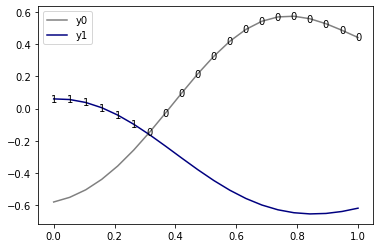

In [3]:
def plot_design_space(n_facets, d, ys, colors=["grey", "navy"]):
    """
    Plot 1 or 2 dimensional design space 
    
    Parameters
    ----------
    n_facets: int >= 1
        number of dimensions in the experiment design space `D`
        
    d: np.array(n, n_facets)
        Points in the design space. 
        - each row is a different point in the space
        - each column is a coordinate along a different dimension in the design space 
        
    ys: np.array(n, n_conditions)
        Outcome values
        - one row for each point in the design space
        - one column for each treatment condition
        
    """
    leading= ys.argmax(axis=0)
    n_conditions = ys.shape[0]

    if n_facets == 1:
        #plt.figure(figsize=(6,4))
        for i in range(n_conditions):
            plt.plot(d, ys[i], label="y%i"%i, color=colors[i])
        for which, pos in zip(leading, d):
            plt.annotate(which, (pos, ys[which][np.argwhere(d==pos)[0,0]]), ha="center", va="center")  
        plt.legend()

    elif n_facets == 2:
        #plt.figure(figsize=(4*n_conditions,4))
        for i in range(n_conditions):
            plt.subplot(1,n_conditions,i+1)
            plt.tricontourf(*d.T, ys[i], cmap="bwr")
            plt.title("y%i"%i)
        plt.colorbar()

        plt.figure(figsize=(4,4))
        plt.tricontourf(*d.T, leading)
        for which, pos in zip(leading, d):
            plt.annotate(which, pos, ha="center", va="center")
        plt.title(r"Leading Condition")
        
    else:
        print("Can't plot more than 2-dimensional design space")
    
plot_design_space(n_facets, d_exhaustive, μ_true)

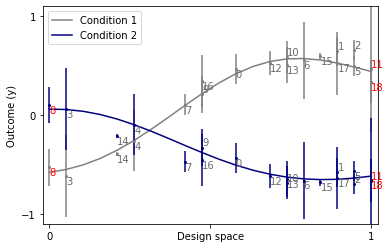

In [4]:
def choose_js(d_exhaustive, μ_true, J):
    """
    Choose a set of microexperiments to conduct.
    Each microexperiment will have a particular mean that is sampled with noise around μ_true
    this mean varies from the mean of all microexperiments that could have been conducted at that location.
    
    
    Parameters
    ----------
    d_exhaustive: np.array(n_levels^n_facets, n_facets)
        All possible points in the design space that the micro-experiments could be chosen from
        - each row is a different point in the space that has a defined ground truth
        - each column is a coordinate along a different dimension in the design space
        
    μ_true: np.array(n_levels^n_facets, n_conditions)
        Expected value for each treatment condition across all microexperiments that could have been
        conducted at each point in d_exhaustive
        - one row for each point in the design space
        - one column for each treatment condition
    
    J: integer >=1 
        number of microexperiments to conduct
        
        
    Returns
    -------
    d_j: np.array(J, n_facets)
        Locations of each micro-experiment `j` in design space `D`
        
    μ_j: np.array(J, n_conditions)
        Expected value of each condition for each realized micro-experiment
        These are sampled from μ_true with noise
        
    σ_j: np.array(J)
        Noise realized in sampling each micro-experiment
        
    ds: np.array(number of unique locations sampled)
        Unique locations containing one or more micro-experiments
        
    d_index: np.array(J)
        index of each microexperiment in `ds`
    """
 
    n_conditions = μ_true.shape[0]
    #indices = np.linspace(0,len(d_exhaustive)-1, J).astype(int)  # taking a sample at J evenly spaced points
    indices = rng.integers(len(d_exhaustive), size=J)
    d_j = np.array([d_exhaustive[index,:] for index in indices])

    σμ = .08  # std between multiple microexperiments run at the same point in the design space
    σσ = .08  # average scale of noise of each microexperiment
    
    μ_j = np.array([μ_true[:,index] + rng.normal(scale=σμ, size=n_conditions) for index in indices]) 
    σ_j = rng.gamma(shape=2, scale=σσ, size=J)

    ds = np.unique(d_j, axis=0)  # list of different locations in D-space where we have micro-experiments
    d_index = np.array([np.argwhere(np.all(ds==d, axis=1))[0,0] for d in d_j])  # index of jth microexperiment in ds
    
    assert (all(d_j == ds[d_index]))  # check that we got the arrays right
    return d_j, μ_j, σ_j, ds, d_index


J=19
d_j, μ_j, σ_j, ds, d_index = choose_js(d_exhaustive, μ_true, J)

# plot

# todo: use largest double point
if np.argwhere(d_j == np.max(d_j)).shape[0]>1:
    j_plot = [np.argmin(d_j), np.argwhere(d_j == np.max(d_j))[0,0], np.argwhere(d_j == np.max(d_j))[1,0]]
else:
    print("")

ax = plt.subplot(111)
plt.plot(d_exhaustive, μ_true[0,:], color='grey', label="Condition 1")
plt.plot(d_exhaustive, μ_true[1,:], color='navy', label="Condition 2")
plt.legend(loc="upper left")
plt.errorbar(d_j, μ_j[:,0], σ_j, color='grey', fmt='.', ms=4)
plt.errorbar(d_j, μ_j[:,1], σ_j, color='navy', fmt='.', ms=4)

ax.set_ylim(-1.1, 1.1)
ax.set_yticks([-1,0,1])
ax.set_xticks([0,.5,1])
ax.set_xticklabels([0,"Design space",1])
# ax.set_xticks([0,1])
ax.set_xlim(-.02, 1.02)
# plt.xlabel("Design space (d)")
plt.ylabel("Outcome (y)")

for i in range(len(d_j)):
    c = 'r' if i in j_plot else 'dimgrey'
    di = d_j[i]
    matches = np.where(di==d_j)[0]  # other microexperiments in this location
    if np.all(matches <= i):  # last one
        va="top"
    else:
        va="bottom"

    plt.annotate(i, (di, μ_j[i,0]), ha="left", va=va, color=c)  
    plt.annotate(i, (di, μ_j[i,1]), ha="left", va=va, color=c)

In [5]:
def generate_random_sample_points(J, d_j, n_conditions, n):
    """
    Choose some random points and conditions
    
    Parameters
    ----------
    J: integer >=1 
        number of microexperiments available
        
    d_j: np.array(J, n_facets)
        Design-space locations of each micro-experiment available
        
    n_conditions: int >= 1
        number of different treatment conditions available
        
    n: int >= 1
        number of sample points to generate
        
    Returns
    -------
    j: np.array(n)
        indices of the microexperiments from which each sample is taken
        
    d: np.array(n, n_facets)
        design space locations of each sample
        
    X: np.array(n)
        indices of treatment conditions for each sample
    
    """
    j = rng.integers(J, size=n)  # group of the ith sample
    d = d_j[j]  # design space location of the ith sample
    X = rng.integers(n_conditions, size=n)
    return j, d, X

n=60
j, d, X = generate_random_sample_points(J, d_j, n_conditions, n)

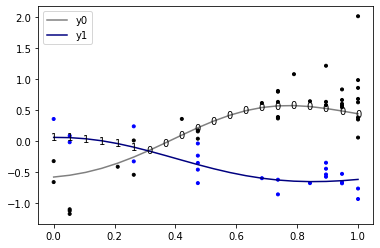

In [6]:
def make_sampler(μ_j, σ_j):
    """
    Create a function returning samples from micro-experiments
    
    Parameters
    ----------
    μ_j: np.array(J, n_conditions)
        Expected value of each condition for each micro-experiment
        These are sampled from μ_true with noise
        
    σ_j: np.array(J)
        Noise with which each micro-experiment is sampled
    
    Returns
    -------
    sample(j, X): function
    
    """
    def sample(j, X):
        """
        Take a sample from the 'real world'
        
        Parameters
        ----------
        j: np.array(n)
            indices of the microexperiments from which each sample is taken
            
        X: np.array(n)
            indices of treatment conditions for each sample
        
        """
        y = [μ_j[ji][Xi] + rng.normal(scale=σ_j[ji]) for ji, Xi in zip(j, X)]
        return  y
    return sample
        
take_samples = make_sampler(μ_j, σ_j)
    
y = take_samples(j, X)

plot_design_space(n_facets, d_exhaustive, μ_true)
plt.scatter(d,y, c=['k' if Xi==0 else 'b' for Xi in X], marker='.');


# Space-covering statistical models

### Completely pooled model

Perform a single regression using all datapoints, regardless of their location in the design space.

$
\begin{aligned}
    y_{i}  &\sim \mathcal{N}(\mu_{X[i]},\,\sigma)  & \text{for $i=0 \ldots n-1$}\\
    \mu_{X} &= \mathcal{N}(0,\,1) & \text{for } X \in \left\{0\text{: individuals}, 1\text{: groups} \right\}\\
    \sigma &\sim \mathcal{\Gamma}(2,0.5) \\
    \Delta \mu &= \mu_{X=1} - \mu_{X=0}
\end{aligned}
$

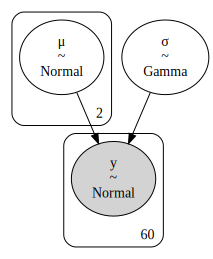

In [7]:
def build_pooled_model(J, n_conditions, j, X, y):
    
    with pm.Model() as model:
        # Prior for mean
        μ_ = pm.Normal("μ", mu=0, sigma=1, shape=n_conditions)
        
        # Prior for noise
        σ_ = pm.Gamma("σ", alpha=2, beta=0.5)

        # assume that observations are sampled with gaussian noise
        y_ = pm.Normal("y", mu=μ_[X], sd=σ_, observed=y)
        
    return model

complete_pooling = build_pooled_model(J, n_conditions, j, X, y)
pm.model_to_graphviz(complete_pooling)

In [8]:
with complete_pooling:
    complete_pooling_trace = pm.sample()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


### Unpooled model

Perform a separate regression for each of $J$ microexperiments.


$\newcommand{\highlight}{\color{red}}$
$
\begin{aligned}
    y_{i}  &\sim \mathcal{N}(\mu_{{\highlight{j[i]}X[i]}},\,\sigma_{\highlight{j[i]}})  & \text{for } i=0 \ldots n-1\\
    \mu_{{\highlight{j}}X} &= \mathcal{N}(0,\,1) & \text{for } X \in \left\{0, 1\right\},{\highlight{~j=0 \ldots J-1}}\\
    \sigma_{\highlight{j}} &\sim \mathcal{\Gamma}(2,0.5) &\highlight{\text{for } j=0 \ldots J-1}\\
    \Delta \mu_{\highlight{j}} &= \mu_{{\highlight{j}}X=1} - \mu_{{\highlight {j}}X=0} &\highlight{\text{for } j=0 \ldots J-1}
\end{aligned}
$



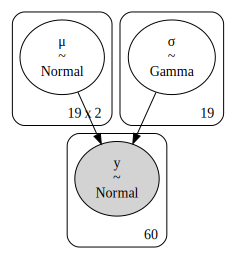

In [9]:
def build_unpooled_model(J, n_conditions, j, X, y):
    """
    A factory method to encapsulate creation of unpooled regression models. 
    Allows us to create multiple instances of the same model with different paramterizations, 
    without the risk that model-local variable names will conflict with other models.
    """
    with pm.Model() as model:
        μ_ = pm.Normal("μ", mu=0, sigma=1, shape=(J, n_conditions))
        σ_ = pm.Gamma("σ", alpha=2, beta=0.5, shape=J)
        
        # Observations sampled with gaussian noise
        y_ = pm.Normal("y", mu=μ_[j,X], sd=σ_[j], observed=y)
        
    return model

no_pooling = build_unpooled_model(J, n_conditions, j, X, y)
pm.model_to_graphviz(no_pooling)

In [10]:
with no_pooling:
    no_pooling_trace = pm.sample()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
There were 246 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


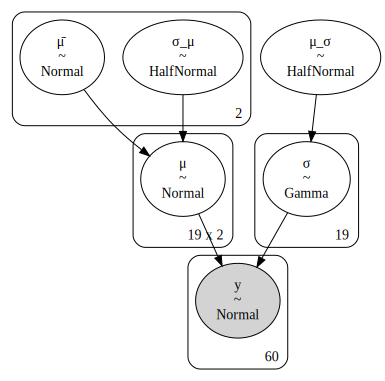

In [11]:
def build_partial_pooled_model(J, n_conditions, j, X, y):
    
    with pm.Model() as model:
        # hyperpriors for slope, intercept, noise across design space
        μ̄_ = pm.Normal("μ̄", 0, sigma=1, shape=n_conditions)  # mean for effects prior
        σμ_ = pm.HalfNormal("σ_μ", sigma=1, shape=n_conditions)  # std for effects prior 
        μσ_ = pm.HalfNormal("μ_σ", sigma=1)  # scale parameter for noise prior

        # Prior for noise

        μ_ = pm.Normal("μ", mu=μ̄_, sigma=σμ_, shape=(J, n_conditions))
        σ_ = pm.Gamma("σ", alpha=2, beta=μσ_, shape=J)

        # Observations sampled with gaussian noise
        y_ = pm.Normal("y", mu=μ_[j,X], sd=σ_[j], observed=y)
        
    return model
        
    
partial_pooling = build_partial_pooled_model(J, n_conditions, j, X, y)
pm.model_to_graphviz(partial_pooling)

In [12]:
with partial_pooling:
    partial_pooling_trace = pm.sample()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
There were 401 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7039212695671084, but should be close to 0.8. Try to increase the number of tuning steps.
There were 697 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7083251232863863, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


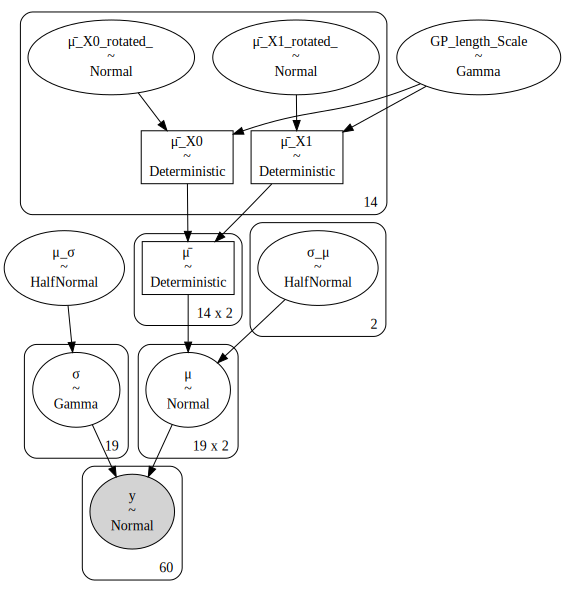

In [13]:
def build_functional_partial_pooled_model(J, n_conditions, j, X, y, ds, n_facets, d_index):
    
    with pm.Model() as model:
        
        # hyper-hyperpriors for gaussian process
        gp_length_scale_ = pm.Gamma("GP_length_Scale", alpha=2, beta=1, shape=n_facets)  # allow a different length scale for each facet
        
        # hyperpriors for slope and intercept
        cov_func = pm.gp.cov.ExpQuad(n_facets, ls=gp_length_scale_)
        gp_μ̄_ = [pm.gp.Latent(cov_func=cov_func) for i in range(n_conditions)]  # one GP for each treatment
        μ̄_ = pm.Deterministic("μ̄", pm.math.stack([gpi.prior("μ̄_X%i"%i, X=ds, shape=len(ds)) for i, gpi in enumerate(gp_μ̄_)]).T)  # mean for effects prior
      
        σμ_ = pm.HalfNormal("σ_μ", sigma=1, shape=n_conditions)  
        μσ_ = pm.HalfNormal("μ_σ", sigma=1)  # scale parameter for noise prior
    
        # Prior for noise

        μ_ = pm.Normal("μ", mu=μ̄_[d_index,:], sigma=σμ_, shape=(J, n_conditions))
        σ_ = pm.Gamma("σ", alpha=2, beta=μσ_, shape=J)

        # Observations sampled with gaussian noise
        y_ = pm.Normal("y", mu=μ_[j,X], sd=σ_[j], observed=y)
        
    return model
        
    
functional_partial_pooling = build_functional_partial_pooled_model(J, n_conditions, j, X, y, ds, n_facets, d_index)
pm.model_to_graphviz(functional_partial_pooling)



In [14]:
with functional_partial_pooling:
    functional_partial_pooling_trace = pm.sample()

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 231 seconds.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
There were 485 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6842933125577431, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [25]:
try:
    pd.to_pickle(
        [no_pooling_trace, 
         complete_pooling_trace, 
         partial_pooling_trace, 
         functional_partial_pooling_trace
        ],
    "traces.pickle"
    )
except:
    no_pooling_trace, complete_pooling_trace, partial_pooling_trace, functional_partial_pooling_trace = pd.read_pickle("traces.pickle")

## Plot results

In [18]:
plt.rcParams.update({
    "figure.dpi": 100,
    "figure.figsize": (4.5, 4),  # inches
    "figure.facecolor": "white", #"lightyellow",
    
    "savefig.dpi": 150,
    
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 8,
    
    "lines.linewidth": 1,
    "lines.markersize": 2,
    
    "axes.labelsize": 7,
    
    "xtick.labelsize": 6,
    "xtick.major.size": 1,
    
    "ytick.major.size": 0,
    "ytick.labelsize": 6,

    "axes.spines.left": True,
    "axes.spines.right": True,
    "axes.spines.top": True,
    'axes.edgecolor': "silver",
    "axes.linewidth": .5,
    
    "text.usetex": False,
    'mathtext.default': 'regular',

    'legend.fontsize': 6,
    
})

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


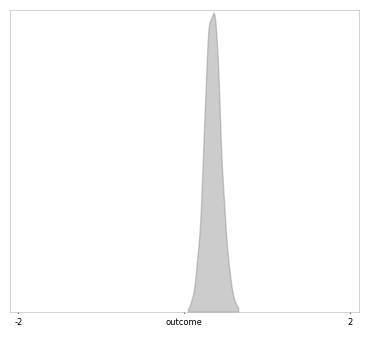

In [16]:
from scipy import stats
def kde(data, ax=None, n_pts=50, true_val=None, color="grey"):
    density = stats.kde.gaussian_kde(data)
    x = numpy.linspace(np.min(data), np.max(data), n_pts)
    y = density(x)
    if ax is None:
        ax=plt.subplot(111)
    ax.fill_between(x, 0, y, color=color, alpha=.4)
    
    if true_val is not None:
        #plt.vlines(x=true_val, ymin=0, ymax=np.interp(true_val, x, y), color=color, linestyles='--') 
        plt.vlines(x=true_val, ymin=0, ymax=10, color=color, linestyles='--') 

    ax.set_xlim(-2.1,2.1)
    ax.set_ylim(0,4)
    ax.set_xticks([-2,0,2])
    ax.set_xticklabels([-2,'outcome',2])
    ax.set_yticks([])

    
kde(complete_pooling_trace['μ'][:,0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:184: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


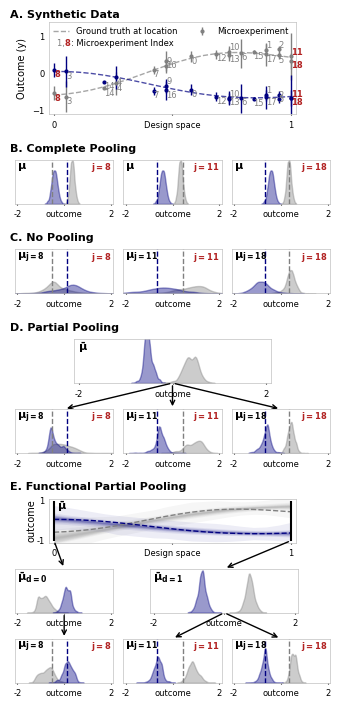

In [23]:
#d_exhaustive#j_plot = [np.argmin(d_j), np.argwhere(d_j == np.median(d_j))[0,0], np.argmax(d_j)]

# todo: use largest double point
if np.argwhere(d_j == np.max(d_j)).shape[0]>1:
    j_plot = [np.argmin(d_j), np.argwhere(d_j == np.max(d_j))[0,0], np.argwhere(d_j == np.max(d_j))[1,0]]
else:
    print("")

fig = plt.figure(figsize=(3.25, 6.5), dpi=100, 
                 #facecolor="lightyellow", 
                 constrained_layout=True)


# horizontal positions of subplots
h_margin =.015
sm_h = .03
n_xitems = 3
width = (1 - 2*h_margin - 2*sm_h)/n_xitems
x_seq = [h_margin, width + sm_h, width + sm_h]
x = np.cumsum(x_seq)
assert len(x) == n_xitems
x_text=0.0

# vertical positions of subplots
v_margin =.01
lg_v = .07  # large vertical gap
sm_v = .04
n_yitems = 9
height = (1 - 2*v_margin - 4*lg_v - 3*sm_h)/n_yitems

y_seq = [v_margin, height+ sm_v, height + sm_v, height + lg_v, height + sm_v, height + lg_v, height + lg_v, height + lg_v]
ypos = np.cumsum(y_seq)


# synthdata
plt.figtext(x_text, ypos[7]+2*height+.01, "A. Synthetic Data", va="bottom", ha="left", fontweight="bold")

ax = fig.add_axes([x[1]-.75*width, ypos[7],  2.5*width, height*2.1])
plt.plot(d_exhaustive, μ_true[0,:], '--', color='grey', label="Ground truth at location", alpha=.7)
plt.plot(d_exhaustive, μ_true[1,:], '--', color='navy', alpha=.7)

plt.errorbar(d_j, μ_j[:,0], σ_j, color='grey', fmt='.', ms=4, label="Microexperiment")
plt.errorbar(d_j, μ_j[:,1], σ_j, color='navy', fmt='.', ms=4)
plt.legend(loc=(0.0, .81), ncol=2, frameon=False)

ax.set_ylim(-1.1, 1.4)
ax.set_yticks([-1,0,1])
ax.set_xticks([0,.5,1])
ax.set_xticklabels([0,"Design space",1])
ax.set_xlim(-.02, 1.02)
plt.ylabel("Outcome (y)")
plt.annotate("1, ", (.03,.74), color='grey', fontsize=6, fontweight=None, textcoords='axes fraction')
plt.annotate("8", (.06,.74), color='firebrick', fontsize=6, fontweight='bold', textcoords='axes fraction')
plt.annotate(": Microexperiment Index", (.09,.74), color='k', fontsize=6, fontweight=None, textcoords='axes fraction')


for i in range(len(d_j)):
    c = 'firebrick' if i in j_plot else 'grey'
    fw = "bold" if i in j_plot else None
    di = d_j[i]
    matches = np.where(di==d_j)[0]  # other microexperiments in this location
    if np.all(matches <= i):  # last one
        va="top"
    else:
        va="bottom"

    plt.annotate(i, (di, μ_j[i,0]), ha="left", va=va, color=c, fontsize=6, fontweight=fw)  
    plt.annotate(i, (di, μ_j[i,1]), ha="left", va=va, color=c, fontsize=6, fontweight=fw)



# complete pooling
plt.figtext(x_text, ypos[6]+height+.01, "B. Complete Pooling", va="bottom", ha="left", fontweight="bold")

for i, ji in enumerate(j_plot):
    ax = fig.add_axes([x[i], ypos[6],  width, height])
    kde(complete_pooling_trace['μ'][:,0], ax=ax, color='grey', true_val=μ_j[ji][0])
    kde(complete_pooling_trace['μ'][:,1], ax=ax, color='navy', true_val=μ_j[ji][1])
    ax.text(.02,.98, r'$\mu$', va="top", weight="bold", transform=ax.transAxes)
    ax.text(.98,.98, r'$j=%i$'%ji, va="top", ha="right", color="firebrick", weight="bold", fontsize=6, transform=ax.transAxes)



# no pooling
plt.figtext(x_text, ypos[5]+height+.01, "C. No Pooling", va="bottom", ha="left", fontweight="bold")

for i, ji in enumerate(j_plot):
    ax = fig.add_axes([x[i], ypos[5],  width, height])
    kde(no_pooling_trace['μ'][:,ji,0], ax=ax, color='grey', true_val=μ_j[ji][0])
    kde(no_pooling_trace['μ'][:,ji,1], ax=ax, color='navy', true_val=μ_j[ji][1])
    ax.text(.02,.98, r'$\mu_{j=%i}$'%ji, va="top", weight="bold", transform=ax.transAxes)
    ax.text(.98,.98, r'$j=%i$'%ji, va="top", ha="right", color="firebrick", weight="bold", fontsize=6, transform=ax.transAxes)

# partial pooling
plt.figtext(x_text, ypos[4]+height+.01 , "D. Partial Pooling", va="bottom", ha="left", fontweight="bold")
ax = fig.add_axes([x[1]-.5*width, ypos[4],  2*width, height])
kde(partial_pooling_trace['μ̄'][:,0], ax=ax, color='grey')
kde(partial_pooling_trace['μ̄'][:,1], ax=ax, color='navy')
ax.text(.02,.98, r'$\bar{\mu}$', va="top", weight="bold", transform=ax.transAxes)
ax_mubar = ax

for i, ji in enumerate(j_plot):
    ax = fig.add_axes([x[i], ypos[3],  width, height])
    kde(partial_pooling_trace['μ'][:,ji,0], ax=ax, color='grey', true_val=μ_j[ji][0])
    kde(partial_pooling_trace['μ'][:,ji,1], ax=ax, color='navy', true_val=μ_j[ji][1])
    ax.text(.02,.98, r'$\mu_{j=%i}$'%ji, va="top", weight="bold", transform=ax.transAxes)
    ax_mubar.annotate("", xy=(.5,0), xytext=(0.5,1), 
                   xycoords=ax_mubar.transAxes,
                   textcoords=ax.transAxes, 
                   arrowprops=dict(facecolor='black', arrowstyle='<-', clip_on=False))
    ax.text(.98,.98, r'$j=%i$'%ji, va="top", ha="right", color="firebrick", weight="bold", fontsize=6, transform=ax.transAxes)




# functional pooling
plt.figtext(x_text, ypos[2]+height+.01 , "E. Functional Partial Pooling", va="bottom", ha="left", fontweight="bold")
ax = fig.add_axes([x[1]-.75*width, ypos[2],  2.5*width, height])
for p in range(0,50,5):
    ax.fill_between(ds.flatten(), *np.percentile(functional_partial_pooling_trace['μ̄'][:,:,0], (p, 100-p), axis=0), color='grey', alpha=.07, linewidth=0)
    ax.fill_between(ds.flatten(), *np.percentile(functional_partial_pooling_trace['μ̄'][:,:,1], (p, 100-p), axis=0), color='navy', alpha=.07, linewidth=0)
ax.set_xticks([0,.5,1])
ax.set_xticklabels([0,"Design space",1])
ax.plot(d_exhaustive.flatten(), μ_true[0], '--', color='grey')
ax.plot(d_exhaustive.flatten(), μ_true[1], '--', color='navy')
ax.set_ylim(-1.1, 1.1)
ax.set_yticks([-1,1])
ax.set_yticklabels([-1, 1])

ax.set_xlim(-.02, 1.02)
ax.text(.03,.98, r'$\bar{\mu}$', va="top", weight="bold", transform=ax.transAxes)
ax.set_ylabel("outcome", labelpad=0)
plt.vlines([0,1], -1, 1, 'k', linewidth=1.5)
ax_fmubar = ax

ax = fig.add_axes([x[0], ypos[1],  width, height])
kde(functional_partial_pooling_trace['μ̄'][:,d_index[j_plot[0]],0], ax=ax, color='grey')
kde(functional_partial_pooling_trace['μ̄'][:,d_index[j_plot[0]],1], ax=ax, color='navy')
ax.text(.02,.98, r'$\bar{\mu}_{d=0}$', va="top", weight="bold", transform=ax.transAxes)
ax_fmu0 = ax

ax = fig.add_axes([x[1]+(width+sm_h)/4, ypos[1],  width*1.5, height])
kde(functional_partial_pooling_trace['μ̄'][:,d_index[j_plot[1]],0], ax=ax, color='grey')
kde(functional_partial_pooling_trace['μ̄'][:,d_index[j_plot[1]],1], ax=ax, color='navy')
ax.text(.02,.98, r'$\bar{\mu}_{d=1}$', va="top", weight="bold", transform=ax.transAxes)
ax_fmu1 = ax

ax_fmubar.annotate("", xy=(0,-1), xytext=(0.5,1), 
                   xycoords=ax_fmubar.transData,
                   textcoords=ax_fmu0.transAxes, 
                   arrowprops=dict(facecolor='black', arrowstyle='<-', clip_on=False))

ax_fmubar.annotate("", xy=(1,-1), xytext=(0.5,1), 
                   xycoords=ax_fmubar.transData,
                   textcoords=ax_fmu1.transAxes, 
                   arrowprops=dict(facecolor='black', arrowstyle='<-', clip_on=False))


ax_fmuj = []
for i, ji in enumerate(j_plot):
    ax = fig.add_axes([x[i], ypos[0],  width, height])
    kde(functional_partial_pooling_trace['μ'][:,ji,0], ax=ax, color='grey', true_val=μ_j[ji][0])
    kde(functional_partial_pooling_trace['μ'][:,ji,1], ax=ax, color='navy', true_val=μ_j[ji][1])
    ax.text(.02,.98, r'$\mu_{j=%i}$'%ji, va="top", weight="bold", transform=ax.transAxes)
    ax_fmuj.append(ax) 
    ax.text(.98,.98, r'$j=%i$'%ji, va="top", ha="right", color="firebrick", weight="bold", fontsize=6, transform=ax.transAxes)


ax_fmu0.annotate("", xy=(.5,0), xytext=(0.5,1), 
                   xycoords=ax_fmu0.transAxes,
                   textcoords=ax_fmuj[0].transAxes, 
                   arrowprops=dict(facecolor='black', arrowstyle='<-', clip_on=False))

ax_fmu1.annotate("", xy=(.5,0), xytext=(0.5,1), 
                   xycoords=ax_fmu1.transAxes,
                   textcoords=ax_fmuj[1].transAxes, 
                   arrowprops=dict(facecolor='black', arrowstyle='<-', clip_on=False))

ax_fmu1.annotate("", xy=(.5,0), xytext=(0.5,1), 
                   xycoords=ax_fmu1.transAxes,
                   textcoords=ax_fmuj[2].transAxes, 
                   arrowprops=dict(facecolor='black', arrowstyle='<-', clip_on=False))

plt.savefig("fig1_model.png", dpi=200)
